In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install 'git+https://github.com/tensorflow/docs'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-b71l10a5
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-b71l10a5


In [1]:
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, make_scorer
import keras 
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import learning_curve


df = pd.read_csv('/content/drive/My Drive/ProjetoEspecializado/Dataset/clean_transform.csv')
columns = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price']
display(df)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,0,3,0,4,0,0,2.17,1,5953
1,0,0,0,0,1,0,0,2.33,1,5953
2,1,0,0,0,0,0,0,2.17,1,5956
3,2,0,1,0,2,0,0,2.25,1,5955
4,2,0,1,0,1,0,0,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...
300148,2,5,1,1,3,3,1,10.08,49,69265
300149,2,5,2,1,4,3,1,10.42,49,77105
300150,2,5,0,1,4,3,1,13.83,49,79099
300151,2,5,0,1,3,3,1,10.00,49,81585


In [2]:
def normalization(df_fit, df_in):
    df_fit_stats = df_fit.describe()
    df_fit_stats = df_fit_stats.transpose()
    return (df_in-df_fit_stats["min"])/(df_fit_stats["max"]-df_fit_stats["min"])


def standarization(df_fit, df_in):
    df_fit_stats = df_fit.describe()
    df_fit_stats = df_fit_stats.transpose()
    return (df_in-df_fit_stats["mean"])/(df_fit_stats["std"])


def transform_train_val(df_train, df_val, type_transform):
    if type_transform == 'normalization':
        df_train_transf = normalization(df_train, df_train)
        df_val_transf = normalization(df_train, df_val)
    elif type_transform == 'standarization':
        df_train_transf = standarization(df_train, df_train)
        df_val_transf = standarization(df_train, df_val)
    else:
        df_train_transf, df_val_transf = df_train, df_val
    return df_train_transf, df_val_transf


# Função inversa apenas y_val
def invnorm(df_fit, df_in): 
      df_fit_stats = df_fit.describe()
      df_fit_stats = df_fit_stats.transpose()
      return df_in*(df_fit_stats['max']-df_fit_stats['min'])+df_fit_stats['min']


def invstd(df_fit, df_in):
    df_fit_stats = df_fit.describe()
    df_fit_stats = df_fit_stats.transpose()
    return df_in*df_fit_stats['std']+df_fit_stats['mean']


def invransf_val_pred(y_train, y_pred_transf, type_transform):
    if type_transform == 'normalization':
        return invnorm(y_train, y_pred_transf)
    elif type_transform == 'standarization':
        return invstd(y_train, y_pred_transf)
    else:
        return y_pred_transf

#Validação do Modelo

MAE -> Média absoluta do erro

MedAE -> Mediana absoluta do erro -> bom para evitar outliers




In [3]:
def get_r2(y_test, y_predictions):
    #R²
    correlation_matrix = np.corrcoef(y_predictions, y_test)
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2


def evaluate_model(y_test,y_predictions):
    #R²
    print('R²:')
    print(get_r2(y_test, y_predictions))
    print('\n')
    #MAE
    print('MAE:')
    print(mean_absolute_error(y_test, y_predictions))
    print('\n')
    print('MAPE:')
    print(mean_absolute_percentage_error(y_test, y_predictions))
    print('\n')
    return get_r2(y_test, y_predictions), mean_absolute_error(y_test, y_predictions), mean_absolute_percentage_error(y_test, y_predictions)

# Cross Validation

In [4]:
def split_train_test(df):
    x = df.drop('price', axis=1) #Tirar a saída
    y = df['price'] #Saída é o peso
    x = np.asarray(x)
    y = np.asarray(y)
    x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    return x_train_val, x_test, y_train_val, y_test


def get_model(type_model, num_inputs):
    if type_model == 'linear regression':
        model = LinearRegression() #Traça uma linha que representa os pontos amostrais no plano xy
        early_stop = None
    elif type_model == 'random forest':
        model = RandomForestRegressor() #Filtra os dados por diversas perguntas que separam os dados em nós da árvore
        early_stop = None
    return model, early_stop

In [5]:
from keras.saving.saved_model.base_serialization import print_function
def train_and_get_metrics(df_train, df_val, type_model, type_transform, EPOCHS, model, early_stop):
    df_train_transf, df_val_transf = transform_train_val(df_train, df_val, type_transform)        
    y_train = df_train['price']
    y_val = df_val['price']
    x_train_transf = df_train_transf.drop('price', axis=1)
    y_train_transf = df_train_transf['price']
    x_val_transf = df_val_transf.drop('price', axis=1)
    y_val_transf = df_val_transf['price']

    #Treinamento  
    if type_model == 'deep learning':
        model.fit(x_train_transf, y_train_transf, epochs=EPOCHS, validation_data=(x_val_transf, y_val_transf), verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])    
    else:
        model.fit(x_train_transf,y_train_transf)
    y_pred_transf = model.predict(x_val_transf).flatten()
    y_pred_transf = pd.Series(data = y_pred_transf, name='predictions')
    #Calculo dos parametros de validacao
    y_predictions = invransf_val_pred(y_train, y_pred_transf, type_transform)
    # Save model
    #model.save(f'/content/drive/My Drive/ProjetoEspecializado/Modelos/{type_transform}/fold_{count+1}')
    return y_val, y_predictions

In [6]:
# Cross Validation
def cross_validation(df, type_model, type_transform='no_transform'):
    EPOCHS = 100
    n_fold = 5
    kf = KFold(n_splits = n_fold, shuffle=True)

    # Definicao dos vetores de validacao
    r2_arr = np.ndarray(shape=n_fold, dtype=float)
    mae_arr = np.ndarray(shape=n_fold, dtype=float)
    mape_arr = np.ndarray(shape=n_fold, dtype=float)

    count = 0
    #Separacao hold up train test
    x_train_val, x_test, y_train_val, y_test = split_train_test(df)
    df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=0)
    num_inputs = len(df.columns) - 1
    model, early_stop = get_model(type_model, num_inputs)

    for train_index, val_index in kf.split(x_train_val,y_train_val):

        # Separacao dos dados
        df_train = df.iloc[train_index]
        df_val = df.iloc[val_index]
        print(f'Fold:{count}')
        y_val, y_predictions = train_and_get_metrics(df_train, df_val, type_model, type_transform, EPOCHS, model, early_stop)
        r2_arr[count], mae_arr[count], mape_arr[count] = evaluate_model(y_val,y_predictions)
        count+=1

    print('Média:')
    print('R²:')
    print(r2_arr.mean())
    print('\n')
    print('MAE:')
    print(mae_arr.mean())
    print('\n')
    print('MAPE:')
    print(mape_arr.mean())
    print('\n')

    print('Desvio padrão:')
    print('R²:')
    print(r2_arr.std())
    print('\n')
    print('MAE:')
    print(mae_arr.std())
    print('\n')
    print('MAPE:')
    print(mape_arr.std())
    print('\n')
    if type_transform == 'no_transform':
        for metric in ['MAE', 'MAPE', 'R²']:
            plot_train_curve(df_train_val, type_model, metric)


# Treinamento final do modelo para avaliacao
def final_metrics_model(df, type_model, type_transform):
    # Separacao dos dados
    df_train_val, df_test = train_test_split(df, test_size=0.2)
    num_inputs = len(df.columns) - 1
    model, early_stop = get_model(type_model, num_inputs)
    EPOCHS = 60
    before_train = datetime.datetime.now()
    y_val, y_predictions = train_and_get_metrics(df_train_val, df_test, type_model, type_transform, EPOCHS, model, early_stop)
    print('Tempo de execução:')
    print(datetime.datetime.now() - before_train)
    return y_val, y_predictions

In [7]:
def plot_train_curve(df, type_model,metric):
    #Separar x e y para o gráfico
    r_2  = make_scorer(get_r2, greater_is_better=True)
    metrics = {'MAE': 'neg_mean_absolute_error',
           'MAPE': 'neg_mean_absolute_percentage_error',
           'R²': r_2}
    y = df['price']
    x = df.drop('price', axis=1)

    if type_model == 'linear regression':
        train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(), x, y, train_sizes=np.linspace(0.01,1.0,50), scoring=metrics[metric], cv=5)
    elif type_model == 'random forest':
        train_sizes, train_scores, valid_scores = learning_curve(RandomForestRegressor(), x, y, train_sizes=np.linspace(0.01,1.0,50), scoring=metrics[metric], cv=5)
    # Create means and standard deviations of training set scores
    train_mean =np.mean(train_scores, axis=1)
    # Create means and standard deviations of test set scores
    val_mean = np.mean(valid_scores, axis=1)
    # Draw Lines
    df_train_curve = pd.concat([pd.DataFrame(train_sizes, columns =['epochs']), pd.DataFrame(train_mean, columns =['train_metric']), pd.DataFrame(val_mean, columns =['val_metric'])], axis=1)
    plt.figure(figsize=(10,5))
    sns.lineplot(x='epochs', y='train_metric', data=df_train_curve, color = sns.xkcd_rgb['blue'], label="Training score")
    sns.lineplot(x='epochs', y='val_metric', data=df_train_curve, color = sns.xkcd_rgb['red'], label="Validation score")
    plt.title('Learning Curve',fontsize=20)
    plt.xlabel('Epochs',fontsize=15)
    plt.ylabel(metric,fontsize=15)
    plt.show()

In [8]:
def plot_error_predict(y_val, y_predictions):
     y_val.reset_index(drop=True, inplace=True)
     y_predictions.reset_index(drop=True, inplace=True)
     result = pd.concat([y_val, y_predictions], axis=1)
     plt.figure(figsize=(10,5))
     sns.regplot(x='price', y='predictions', data=result, color = sns.xkcd_rgb['sky blue'],
                 line_kws = {'lw': 2 , 'color': 'blue'})
     plt.title('Actual Price  Vs  Predicted Price ',fontsize=20)
     plt.xlabel('Actual Price',fontsize=15)
     plt.ylabel('Predicted Price',fontsize=15)
     plt.show()

In [9]:
def train_all_transform_data(df, type_model, stage='CV'):
    for transform in ['no_transform', 'normalization', 'standarization']:
        print(transform)
        if stage == 'CV':
            cross_validation(df, type_model, transform)
        elif stage == 'Held Up':
            y_val, y_predictions = final_metrics_model(df, type_model, transform)
            evaluate_model(y_val,y_predictions)
            plot_error_predict(y_val, y_predictions)

no_transform
Fold:0
R²:
0.8900750156089181


MAE:
3346.260864907211


MAPE:
0.41782283175434665


Fold:1
R²:
0.8888474768038983


MAE:
3341.185720278086


MAPE:
0.414190396669759


Fold:2
R²:
0.8877004680433994


MAE:
3385.061760672251


MAPE:
0.41275949912786986


Fold:3
R²:
0.8873251369227791


MAE:
3358.155392381642


MAPE:
0.4154974745312407


Fold:4
R²:
0.8881805477781167


MAE:
3351.6041088112106


MAPE:
0.4131853188331369


Média:
R²:
0.8884257290314223


MAE:
3356.45356941008


MAPE:
0.41469110418327065


Desvio padrão:
R²:
0.0009690652955940912


MAE:
15.37426758593464


MAPE:
0.0018279576768807971




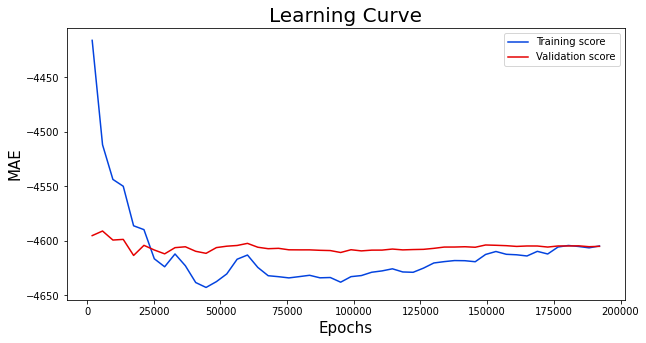

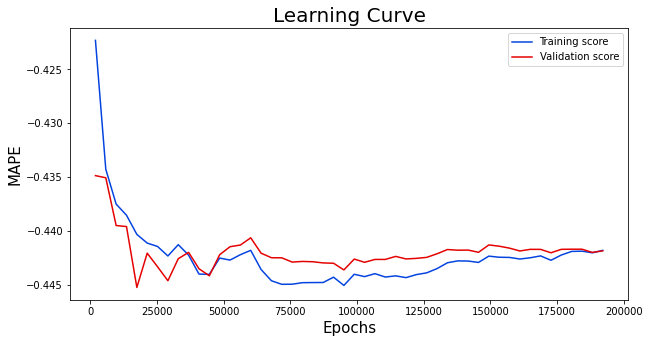

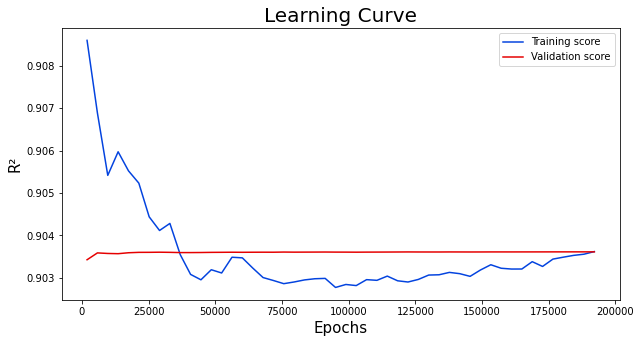

normalization
Fold:0
R²:
0.8871502304692338


MAE:
3390.8489099539984


MAPE:
0.4161163065429223


Fold:1
R²:
0.8903790084707637


MAE:
3341.282072351616


MAPE:
0.41660549414796005


Fold:2
R²:
0.8893648517196716


MAE:
3341.8663923212553


MAPE:
0.40968798146076935


Fold:3
R²:
0.8881353425105089


MAE:
3350.3444765659096


MAPE:
0.4141954941377851


Fold:4
R²:
0.8870846039813977


MAE:
3358.3187742004343


MAPE:
0.41694778032652013


Média:
R²:
0.8884228074303152


MAE:
3356.532125078643


MAPE:
0.4147106113231914


Desvio padrão:
R²:
0.0012811749784045875


MAE:
18.257977209270283


MAPE:
0.00268565230696109


standarization
Fold:0
R²:
0.8878165064590999


MAE:
3364.298573746027


MAPE:
0.41564567091195015


Fold:1
R²:
0.8880036219041358


MAE:
3357.960570453328


MAPE:
0.4151199486197635


Fold:2
R²:
0.8878624931581445


MAE:
3345.1658586157646


MAPE:
0.4134297765652612


Fold:3
R²:
0.888982330030425


MAE:
3364.5419519454267


MAPE:
0.4146781204416098


Fold:4
R²:
0.889419687721

In [10]:
train_all_transform_data(df, 'linear regression', 'CV')

no_transform
Fold:0
R²:
0.9847377587613935


MAE:
811.3839233358948


MAPE:
0.07919761084170064


Fold:1
R²:
0.9840590442892068


MAE:
809.5907325260488


MAPE:
0.07906335141198423


Fold:2
R²:
0.9844504306866958


MAE:
808.0274028655841


MAPE:
0.07946465272633273


Fold:3
R²:
0.9846509308374477


MAE:
818.1800833342422


MAPE:
0.07950204150592424


Fold:4
R²:
0.9846672626181041


MAE:
808.4297493656146


MAPE:
0.07916744123051589


Média:
R²:
0.9845130854385695


MAE:
811.1223782854769


MAPE:
0.07927901954329156


Desvio padrão:
R²:
0.0002463043003753246


MAE:
3.716306458056414


MAPE:
0.00017308282058061685




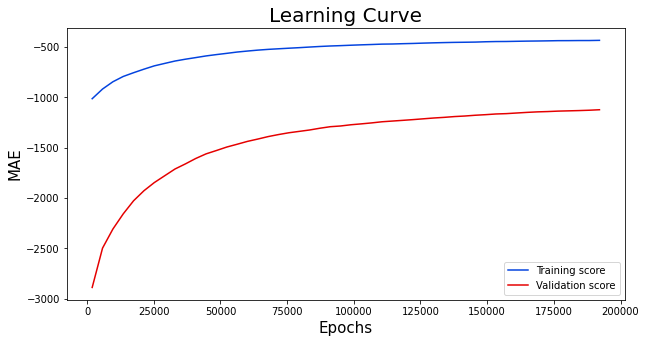

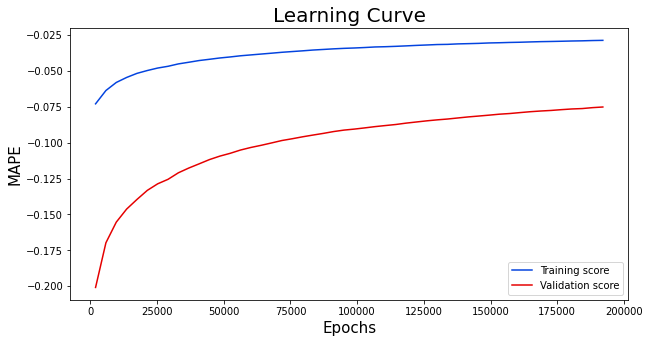

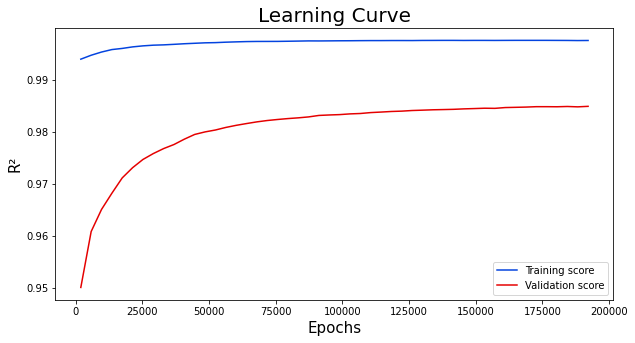

normalization
Fold:0
R²:
0.9844244045951177


MAE:
813.5384777565451


MAPE:
0.07940906445039288


Fold:1
R²:
0.9848131853484372


MAE:
800.088626194776


MAPE:
0.0787667347456998


Fold:2
R²:
0.984295429580053


MAE:
814.2408160732901


MAPE:
0.07822171347815167


Fold:3
R²:
0.9845571522712507


MAE:
814.7850621300956


MAPE:
0.07978117391401364


Fold:4
R²:
0.9836615491749672


MAE:
818.8919527643615


MAPE:
0.07969431333588044


Média:
R²:
0.9843503441939652


MAE:
812.3089869838138


MAPE:
0.07917459998482769


Desvio padrão:
R²:
0.000384689654433285


MAE:
6.388226915245377


MAPE:
0.0005945341423900579


standarization
Fold:0
R²:
0.9834831925862395


MAE:
822.7171332267454


MAPE:
0.07971266406483231


Fold:1
R²:
0.9847868851034834


MAE:
802.745777631941


MAPE:
0.07790091009019645


Fold:2
R²:
0.9844662125271888


MAE:
813.7075890547728


MAPE:
0.07994151970507887


Fold:3
R²:
0.9839150403337621


MAE:
827.129045882237


MAPE:
0.07983444931346599


Fold:4
R²:
0.9845376027613615

In [11]:
train_all_transform_data(df, 'random forest', 'CV')

# Avaliação da Rede Neural (Depois da validação) - Para tirar as métricas finais do modelo

no_transform
Tempo de execução:
0:00:00.085486
R²:
0.9041167825187598


MAE:
4583.5186069087695


MAPE:
0.43992731089263676




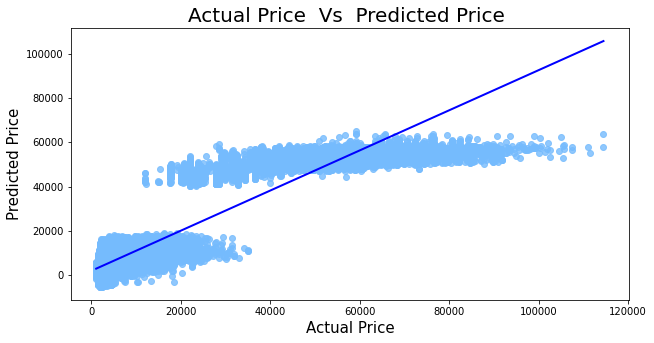

normalization
Tempo de execução:
0:00:00.345909
R²:
0.9036156951444262


MAE:
4600.344342309784


MAPE:
0.44193838458760065




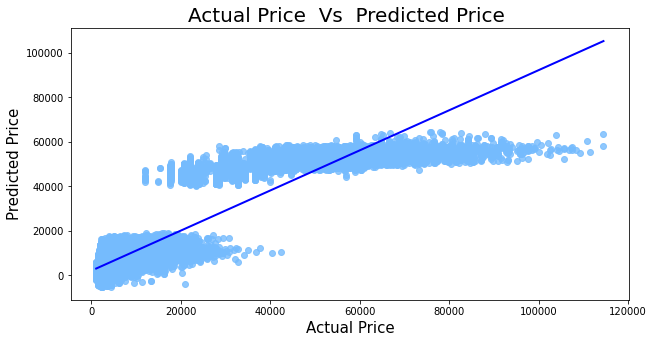

standarization
Tempo de execução:
0:00:00.343829
R²:
0.9051119362110001


MAE:
4574.754652698442


MAPE:
0.44048561662574204




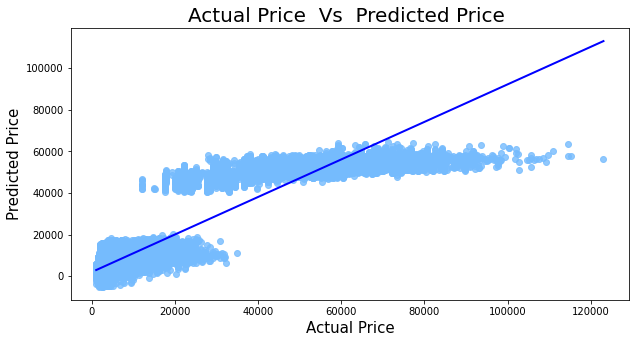

In [12]:
train_all_transform_data(df, 'linear regression', 'Held Up')

no_transform
Tempo de execução:
0:01:06.877897
R²:
0.985136000234073


MAE:
1085.8505447762343


MAPE:
0.07139409067492104




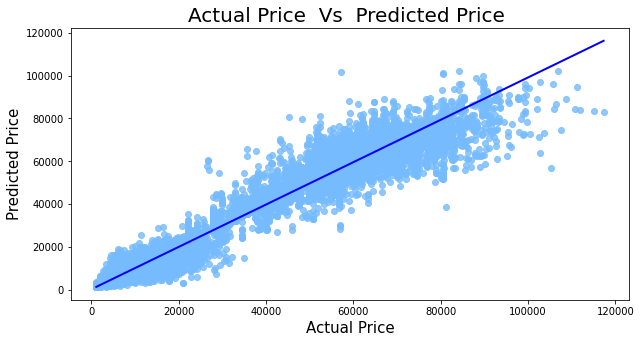

normalization
Tempo de execução:
0:01:11.841762
R²:
0.9855757506028129


MAE:
1073.08815115234


MAPE:
0.07120717755004471




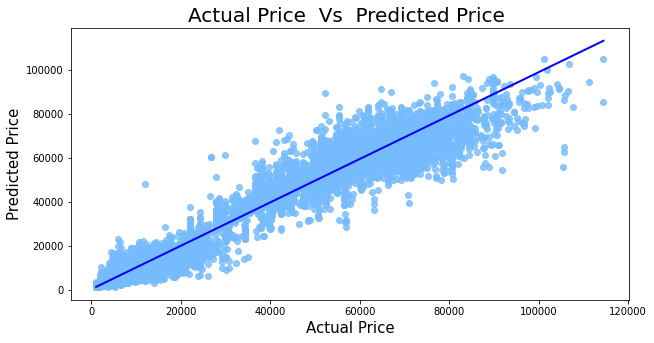

standarization
Tempo de execução:
0:01:06.964174
R²:
0.9856395644423886


MAE:
1073.1383752182458


MAPE:
0.07036812802545238




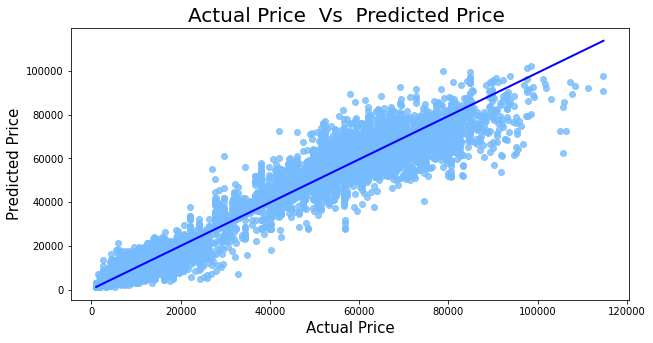

In [13]:
train_all_transform_data(df, 'random forest', 'Held Up')